# <center> Planteamiento 2
El  segundo  planteamiento  propone  una  solución  para  el  caso  en  que  la  frontera cumple  $g = 0$, en donde

$$
u_{NN} = NN(x) \cdot x \cdot (x - π)
$$

Con función de pérdida  

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
$$

Aquí las condiciones de frontera se manejan dentro del modelo de red neuronal en lugar de la función de pérdida. Esto se logra mediante el uso de una capa Lambda que ajusta la salida del modelo para cumplir con las condiciones de frontera.


In [4]:
# pip install keras-core

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras

keras.utils.set_random_seed(1234)
dtype = 'float32'
keras.backend.set_floatx(dtype)

alpha = 0
limInf = 0
limSup = np.pi

neurons = 6
nLayers = 4
nPts = 500
iterations = 500

def makeModel2(neurons, nLayers, activation, limInf=0, limSup=np.pi):
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)
    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)
    boundaryC = keras.layers.Lambda(lambda x: (x - limInf) * (x - limSup))(xVals)
    output = keras.layers.Multiply()([output, boundaryC])
    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')
    return uModel

class Loss2(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, limInf=0, limSup=np.pi, **kwargs):
        super(Loss2, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.limInf = limInf
        self.limSup = limSup

    def call(self, inputs):
        x = tf.random.uniform([self.nPts], dtype=dtype, minval=self.limInf, maxval=self.limSup)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)
        errorPDE = keras.ops.mean((-duxx + alpha * u - self.f(x)) ** 2)
        return errorPDE

class RelativeErrorCallback(tf.keras.callbacks.Callback):
    def __init__(self, uModel, exactU, nPts):
        super().__init__()
        self.uModel = uModel
        self.exactU = exactU
        self.nPts = nPts

    def on_epoch_end(self, epoch, logs=None):
        Sval = tf.experimental.numpy.linspace(0., np.pi, num=self.nPts*10, dtype=dtype)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(Sval)
            ueval_val = self.uModel(Sval)
            u_x_val = t1.gradient(ueval_val, Sval)
            u_e = self.exactU(Sval)
            ue_x = t1.gradient(u_e, Sval)
        del t1
        errorH01 = tf.reduce_mean((ue_x - u_x_val)**2)
        norm_exact = tf.reduce_mean(ue_x**2)
        relative_error = errorH01 / norm_exact
        logs['relative_error'] = relative_error

def makeLossModel2(uModel, nPts, f, limInf=0, limSup=np.pi):
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)
    loss_output = Loss2(uModel, nPts, f, limInf, limSup)(xVals)
    lossModel = keras.Model(inputs=xVals, outputs=loss_output)
    return lossModel

def trickyLoss(yPred, yTrue):
    return yTrue

def fRhs(x):
    return (alpha + 4) * keras.ops.sin(2 * x)

def exactU(x):
    return keras.ops.sin(2 * x)

def plotResults(uModel, history, exactU, xList, title):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    fig, ax = plt.subplots()
    plt.plot(xList, uModel(xList), color='b')
    plt.plot(xList, exactU(xList), color='m')
    plt.legend(['u_approx', 'u_exact'])
    ax.grid(which='both', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'], color='r')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['loss'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax = plt.subplots()
    plt.plot(history.history['relative_error'], color='b')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(['Relative Error'])
    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.title(title)
    plt.show()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    plt.legend(['Loss', 'Relative Error'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

Using TensorFlow backend


In [ ]:
uModel2 = makeModel2(neurons=neurons, nLayers=nLayers, activation='tanh', limInf=limInf, limSup=limSup)
lossModel2 = makeLossModel2(uModel2, nPts, fRhs, limInf, limSup)

optimizer = keras.optimizers.Adam(learning_rate=10**-3)
lossModel2.compile(optimizer=optimizer, loss=trickyLoss)

relative_error_callback = RelativeErrorCallback(uModel2, exactU, nPts)
history2 = lossModel2.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])

xList = np.array([np.pi / 1000 * i for i in range(1000)])
plotResults(uModel2, history2, exactU, xList, 'Approximation of the solution')

In [2]:
def plotResultsGrid(uModel, history, exactU, xList, title, ax):
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    # Plot u vs u_approx
    ax[0].plot(xList, uModel(xList), color='b')
    ax[0].plot(xList, exactU(xList), color='m')
    ax[0].legend(['u_approx', 'u_exact'])
    ax[0].grid(which='both', axis='both', linestyle=':', color='gray')
    ax[0].set_title(title)

    # Plot loss
    ax[1].plot(history.history['loss'], color='r')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].legend(['loss'])
    ax[1].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot relative error
    ax[2].plot(history.history['relative_error'], color='b')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].legend(['Relative Error'])
    ax[2].grid(which='major', axis='both', linestyle=':', color='gray')

    # Plot loss vs relative error
    ax1 = ax[3]
    ax2 = ax1.twinx()
    ax1.plot(history.history['loss'], 'g-')
    ax2.plot(history.history['relative_error'], 'b-')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='g')
    ax2.set_ylabel('Relative Error', color='b')
    ax1.legend(['Loss'], loc='upper left')
    ax2.legend(['Relative Error'], loc='upper right')
    ax1.grid(which='major', axis='both', linestyle=':', color='gray')

In [3]:
def run_experiments_with_different_fRhs(activation_function):
    functions = [
        {
            'fRhs': lambda x: (alpha + 4) * keras.ops.sin(2 * x),
            'exactU': lambda x: keras.ops.sin(2 * x),
            'title': 'sin(2x)'
        },
        {
            'fRhs': lambda x: 17/4 * keras.ops.sin(2 * x) * keras.ops.cos(x / 2) + 2 * keras.ops.sin(x / 2) * keras.ops.cos(2 * x) + alpha * keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'exactU': lambda x: keras.ops.sin(2 * x) * keras.ops.cos(x / 2),
            'title': 'sin(2x) * cos(x/2)'
        },
        {
            'fRhs': lambda x: - 2 * (6 * x**2 - 6 * np.pi * x + np.pi**2) + alpha * (x**2 * (x - np.pi)**2),
            'exactU': lambda x: x**2 * (x - np.pi)**2,
            'title': 'x^2 * (x - pi)^2'
        },
        {
            'fRhs': lambda x: - (2 * (2 - 6 * x + 3 * x**2) * keras.ops.cos(x) -  (6 - 4 * x - 3 * x**2 + x**3) * keras.ops.sin(x)) 
                            + alpha * (x**3 - 3*x**2 + 2*x) * keras.ops.sin(x),
            'exactU': lambda x: (x**3 - 3*x**2 + 2*x) * keras.ops.sin(x),
            'title': '(x^3 - 3x^2 + 2x) * sin(x)'
        },
        {
            'fRhs': lambda x: - (2 * keras.ops.cos(x) *  keras.ops.cosh(x)) + alpha * keras.ops.sinh(x) * keras.ops.sin(x),
            'exactU': lambda x: keras.ops.sinh(x) * keras.ops.sin(x),
            'title': 'sinh(x) * sin(x)'
        },
        {
            'fRhs': lambda x: - ( ( (8 * x**2) / (1 + x**2)**3 ) - ( 2 / (1 + x**2)**2 ) * keras.ops.sin(x) - 
                            keras.ops.sin(x) / (1 + x**2) - (4 * keras.ops.cos(x)) / (1 + x**2)**2 ) 
                            + alpha * (1 / (1 + x**2)) * keras.ops.sin(x),
            'exactU': lambda x: (1 / (1 + x**2)) * keras.ops.sin(x),
            'title': '(1 / (1 + x^2)) * sin(x)'
        },
    ]

    results = []

    fig, axs = plt.subplots(len(functions), 4, figsize=(20, 5 * len(functions)))

    for i, func in enumerate(functions):
        fRhs = func['fRhs']
        exactU = func['exactU']
        title = func['title']

        uModel2 = makeModel2(neurons=neurons, nLayers=nLayers, activation=activation_function)
        lossModel2 = makeLossModel2(uModel2, nPts, fRhs, limInf, limSup)
        optimizer = keras.optimizers.Adam(learning_rate=10**-3)
        lossModel2.compile(optimizer=optimizer, loss=trickyLoss)

        relative_error_callback = RelativeErrorCallback(uModel2, exactU, nPts)
        history2 = lossModel2.fit(np.array([1.]), np.array([1.]), epochs=iterations, verbose=0, callbacks=[relative_error_callback])

        final_loss = history2.history['loss'][-1]
        final_relative_error = history2.history['relative_error'][-1].numpy()

        results.append({
            'title': title,
            'final_loss': final_loss,
            'final_relative_error': final_relative_error
        })

        xList = np.array([np.pi / 1000 * i for i in range(1000)])
        plotResultsGrid(uModel2, history2, exactU, xList, title, axs[i])

    df_results = pd.DataFrame(results)
    print(df_results)
    plt.tight_layout()
    plt.show()


                        title  final_loss  final_relative_error
0                     sin(2x)    0.369493              0.007906
1          sin(2x) * cos(x/2)    0.433549              0.055292
2            x^2 * (x - pi)^2   15.430795              0.378968
3  (x^3 - 3x^2 + 2x) * sin(x)   17.566368              1.092793
4            sinh(x) * sin(x)   33.135036              1.109611
5    (1 / (1 + x^2)) * sin(x)    0.005265              0.273646


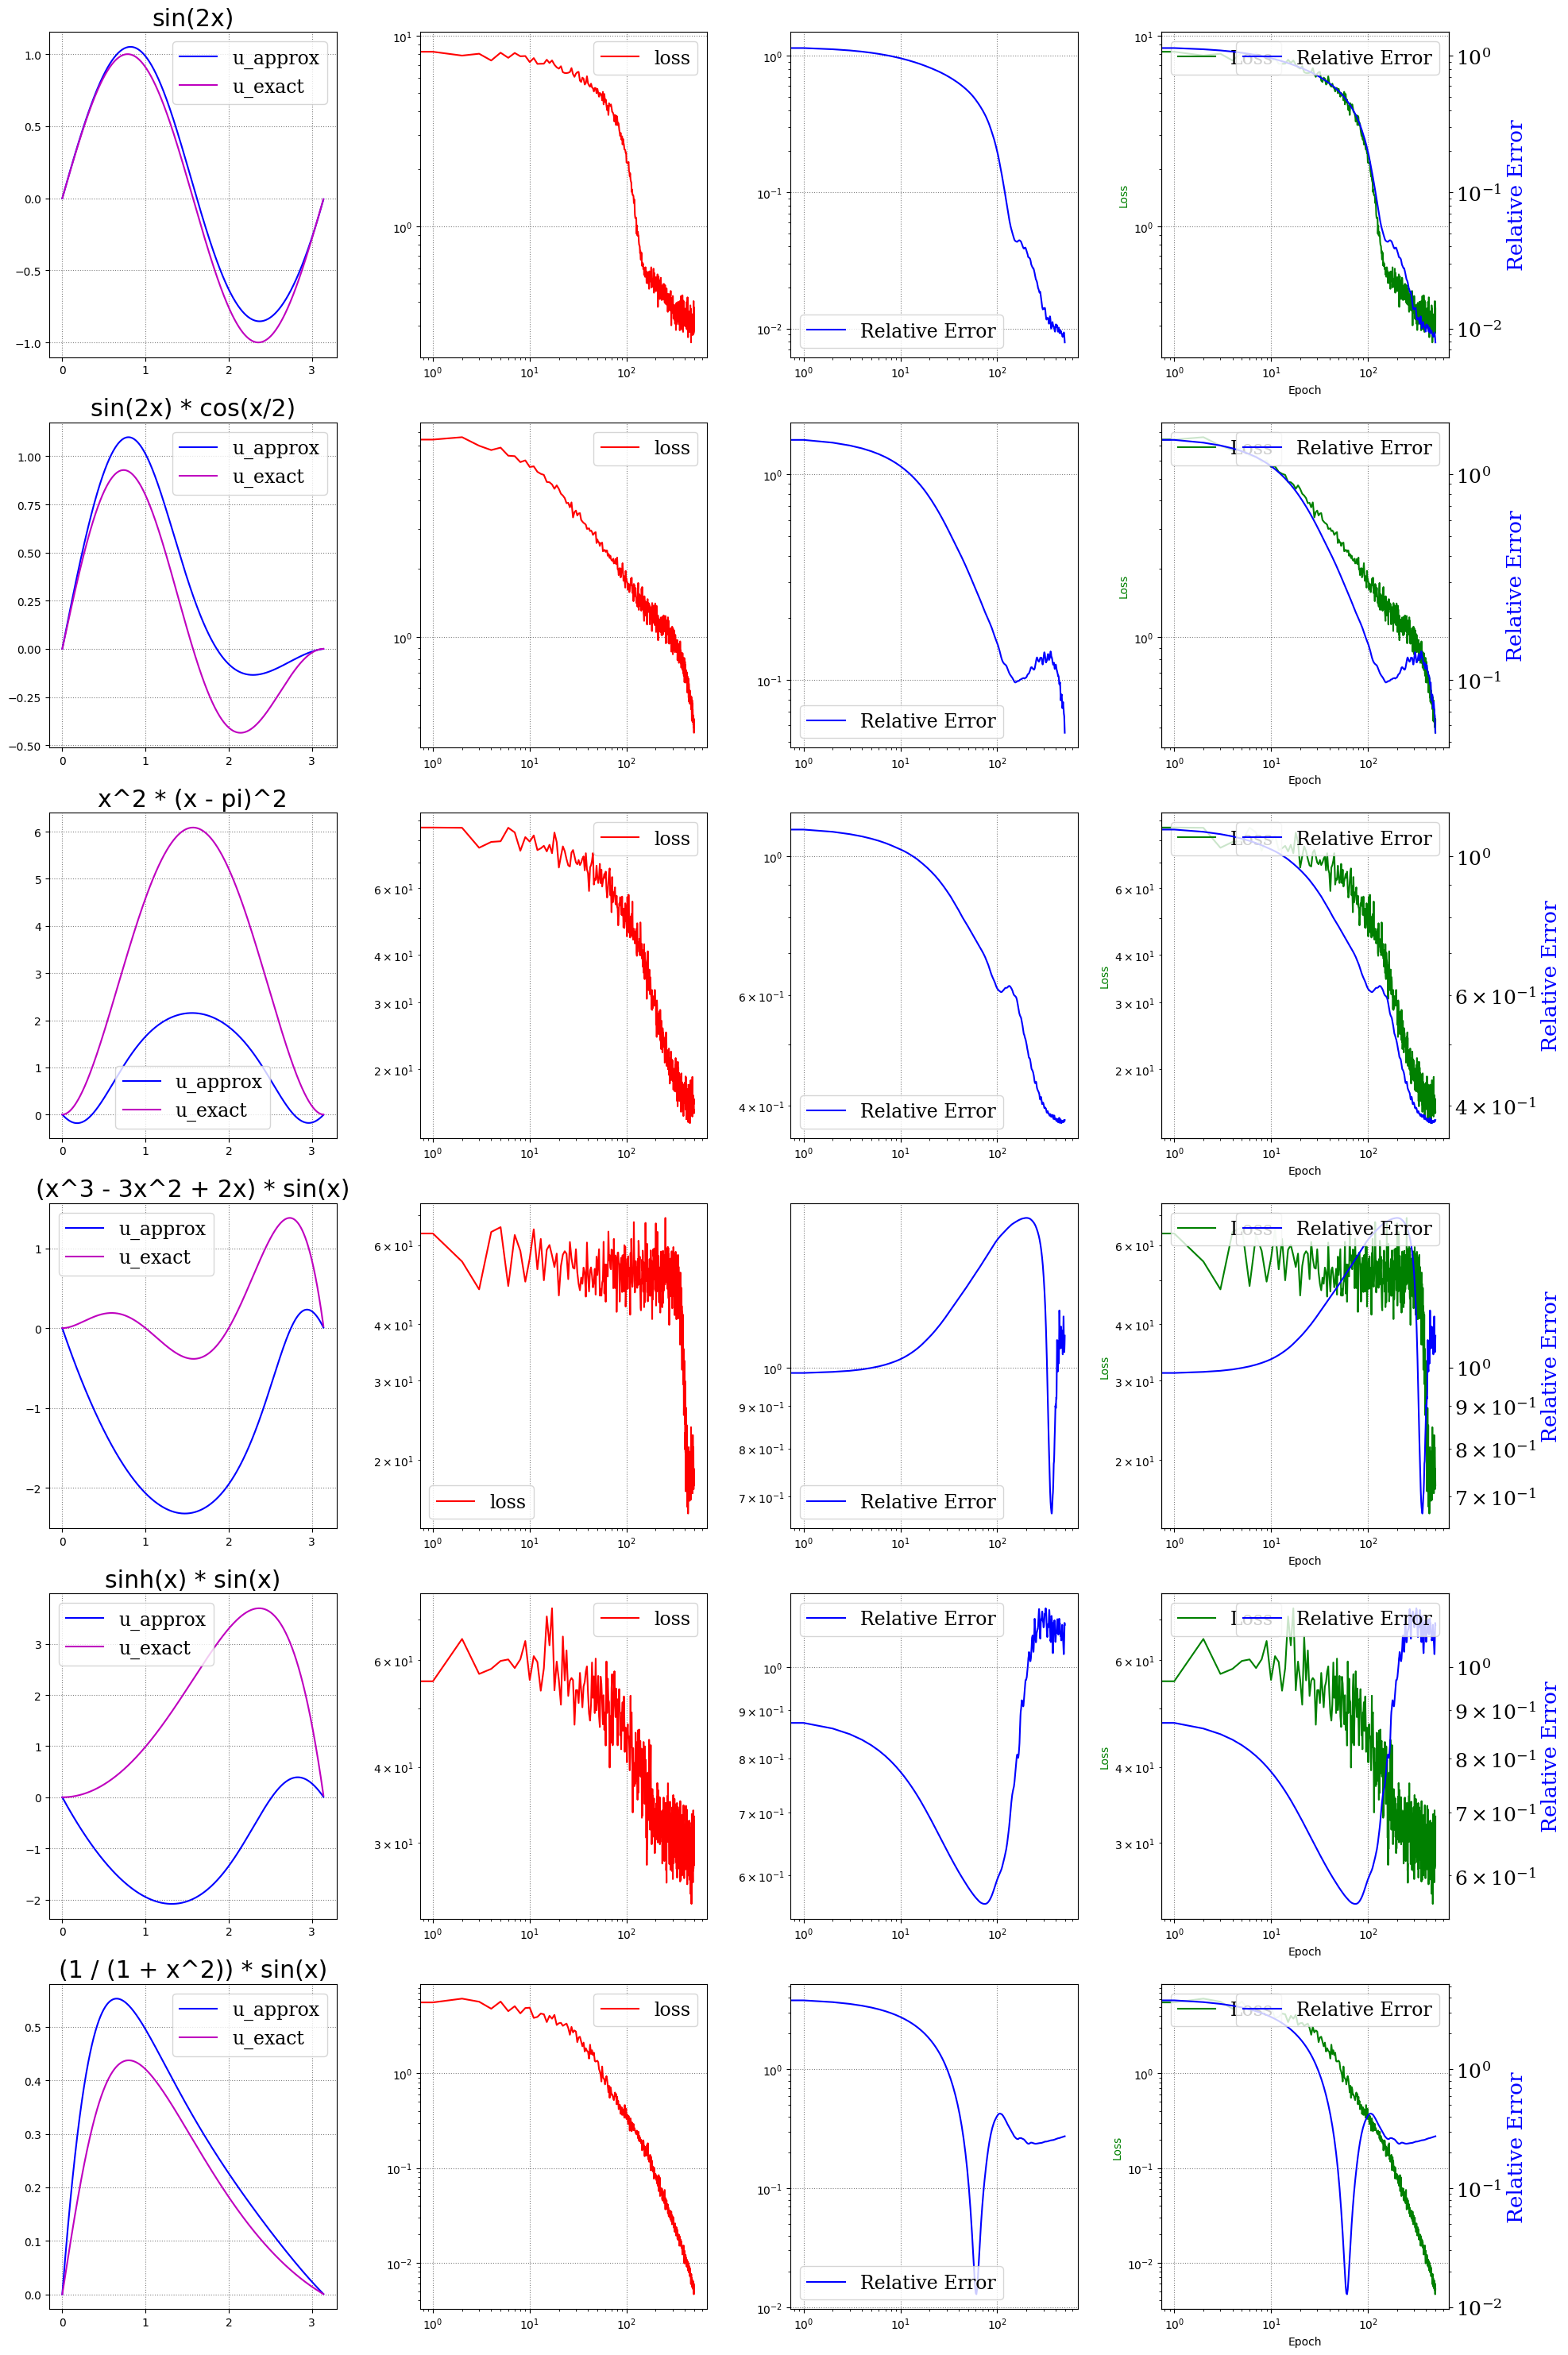

In [4]:
run_experiments_with_different_fRhs('tanh')